### 기본 Search Tool graph

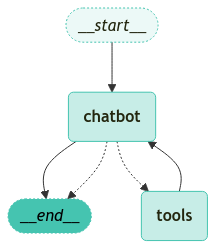

In [1]:
from typing import Annotated
from typing_extensions import TypedDict

from langchain_teddynote.tools.tavily import TavilySearch
from langchain_ollama import ChatOllama
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_teddynote.graphs import visualize_graph


########## 1. 상태 정의 ##########
# 상태 정의
class State(TypedDict):
    # 메시지 목록 주석 추가
    messages: Annotated[list, add_messages]


########## 2. 도구 정의 및 바인딩 ##########
# 도구 초기화
tool = TavilySearch(max_results=3)
# 도구 목록 정의
tools = [tool]

# LLM 초기화
llm = ChatOllama(model="llama3.1:8b")
# 도구와 LLM 결합
llm_with_tools = llm.bind_tools(tools)


########## 3. 노드 추가 ##########
# 챗봇 함수 정의
def chatbot(state: State):
    # 메시지 호출 및 반환
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# 상태 그래프 생성
graph_builder = StateGraph(State)
# 챗봇 노드 추가
graph_builder.add_node("chatbot", chatbot)

# 도구 노드 생성 및 추가
tool_node = ToolNode(tools=tools)
# 도구 노드 추가
graph_builder.add_node("tools", tool_node)

# 조건부 엣지
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

########## 4. 엣지 추가 ##########
# tools > chatbot
graph_builder.add_edge("tools", "chatbot")
# START > chatbot
graph_builder.add_edge(START, "chatbot")
# chatbot > END
graph_builder.add_edge("chatbot", END)

########## 5. 그래프 컴파일 ##########
# 메모리 저장소 초기화
memory = MemorySaver()
# 그래프 빌더 컴파일
graph = graph_builder.compile(checkpointer=memory)

########## 6. 그래프 시각화 ##########
# 그래프 시각화
visualize_graph(graph)


### 1. 중간 단계의 상태(State) 수동 업데이트

##### 특정 단계 메세지 수정하기

In [2]:
from langchain_core.runnables import RunnableConfig

# 질문
question = "LangGraph 가 무엇인지 조사하여 알려주세요!"

# 초기 입력 상태를 정의
input = State(messages=[("user", question)])

# config 설정
config = RunnableConfig(
    configurable={"thread_id": "1"},  # 스레드 ID 설정
)

* 우선 채널목록을 출력하여 `interrupt_before` 와 `interrupt_after` 를 적용할 수 있는 목록을 출력합니다.

In [3]:
# 그래프 채널 목록 출력
list(graph.channels)

['messages',
 '__start__',
 'chatbot',
 'tools',
 'branch:__start__:__self__:chatbot',
 'branch:__start__:__self__:tools',
 'branch:chatbot:__self__:chatbot',
 'branch:chatbot:__self__:tools',
 'branch:tools:__self__:chatbot',
 'branch:tools:__self__:tools',
 'start:chatbot',
 'branch:chatbot:tools_condition:tools']

In [5]:
# 그래프 스트림 호출
events = graph.stream(
    input=input, config=config, interrupt_before=["tools"], stream_mode="values"
)

# 이벤트 반복 처리
for event in events:
    # 메시지가 이벤트에 포함된 경우
    if "messages" in event:
        # 마지막 메시지의 예쁜 출력
        event["messages"][-1].pretty_print()

================================ Human Message =================================

LangGraph 가 무엇인지 조사하여 알려주세요!
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (3af0778b-0e59-448d-8081-7f8ffc087b16)
 Call ID: 3af0778b-0e59-448d-8081-7f8ffc087b16
  Args:
    query: LangGraph가무엇인지를
  tavily_web_search (fd7b4ba9-d103-4de7-a818-59447252d2d0)
 Call ID: fd7b4ba9-d103-4de7-a818-59447252d2d0
  Args:
    query: LangGraph what it is


In [6]:
# 그래프 상태 스냅샷 생성
snapshot = graph.get_state(config)

# 가장 최근 메시지 추출
last_message = snapshot.values["messages"][-1]

# 메시지 출력
last_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (3af0778b-0e59-448d-8081-7f8ffc087b16)
 Call ID: 3af0778b-0e59-448d-8081-7f8ffc087b16
  Args:
    query: LangGraph가무엇인지를
  tavily_web_search (fd7b4ba9-d103-4de7-a818-59447252d2d0)
 Call ID: fd7b4ba9-d103-4de7-a818-59447252d2d0
  Args:
    query: LangGraph what it is


In [7]:
modified_search_result = """[수정된 웹 검색 결과] 
LangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원합니다.
LangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공하는 오픈 소스 라이브러리입니다.

자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/) 과
테디노트의 [랭체인 한국어 튜토리얼](https://wikidocs.net/233785) 을 참고하세요."""

print(modified_search_result)

[수정된 웹 검색 결과] 
LangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원합니다.
LangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공하는 오픈 소스 라이브러리입니다.

자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/) 과
테디노트의 [랭체인 한국어 튜토리얼](https://wikidocs.net/233785) 을 참고하세요.


In [8]:
# 수정하고자 하는 `ToolMessage` 의 `tool_call_id` 추출
tool_call_id = last_message.tool_calls[0]["id"]
print(tool_call_id)

3af0778b-0e59-448d-8081-7f8ffc087b16


In [9]:
from langchain_core.messages import AIMessage, ToolMessage

new_messages = [
    # LLM API의 도구 호출과 일치하는 ToolMessage 필요
    ToolMessage(
        content=modified_search_result,
        tool_call_id=tool_call_id,
    ),
    # LLM의 응답에 직접적으로 내용 추가
    # AIMessage(content=modified_search_result),
]

new_messages[-1].pretty_print()

================================= Tool Message =================================

[수정된 웹 검색 결과] 
LangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원합니다.
LangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공하는 오픈 소스 라이브러리입니다.

자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/) 과
테디노트의 [랭체인 한국어 튜토리얼](https://wikidocs.net/233785) 을 참고하세요.


##### StateGraph의 update_state 메서드

In [10]:
graph.update_state(
    # 업데이트할 상태 지정
    config,
    # 제공할 업데이트된 값. `State`의 메시지는 "추가 전용"으로 기존 상태에 추가됨
    {"messages": new_messages},
    as_node="tools",
)

print("(최근 1개의 메시지 출력)\n")
print(graph.get_state(config).values["messages"][-1])

(최근 1개의 메시지 출력)

content='[수정된 웹 검색 결과] \nLangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원합니다.\nLangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공하는 오픈 소스 라이브러리입니다.\n\n자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/) 과\n테디노트의 [랭체인 한국어 튜토리얼](https://wikidocs.net/233785) 을 참고하세요.' id='1a21d8b7-9ac1-4ebc-a2cc-1c10b08408e3' tool_call_id='3af0778b-0e59-448d-8081-7f8ffc087b16'


In [11]:
snapshot = graph.get_state(config)
snapshot.next

('chatbot',)

In [12]:
# `None`는 현재 상태에 아무것도 추가하지 않음
events = graph.stream(None, config, stream_mode="values")

# 이벤트 반복 처리
for event in events:
    # 메시지가 이벤트에 포함된 경우
    if "messages" in event:
        # 마지막 메시지의 예쁜 출력
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

[수정된 웹 검색 결과] 
LangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원합니다.
LangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공하는 오픈 소스 라이브러리입니다.

자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/) 과
테디노트의 [랭체인 한국어 튜토리얼](https://wikidocs.net/233785) 을 참고하세요.
================================== Ai Message ==================================

LANGGRAPH는 상태 기반의 다중 액터 애플리케이션을 LLM(네크워크 언어 모델)을 활용해 구축할 수 있도록 지원하는 오픈 소스 라이브러리입니다. 이 라이브러리는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공합니다. LANGGRAPH는 사용하기 쉬운 인터페이스를 가지고 있어 개발자들이 빠르게 애플리케이션을 구축할 수 있습니다. LANGGRAPH의 자세한 튜토리얼은 공식 홈페이지에서 확인하실 수 있습니다.


In [13]:
# 그래프 상태 스냅샷 생성
snapshot = graph.get_state(config)

# 최근 세 개의 메시지 출력
for message in snapshot.values["messages"]:
    message.pretty_print()


================================ Human Message =================================

LangGraph 가 무엇인지 조사하여 알려주세요!
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (cc7de106-4695-403c-91f3-a63a0c2ff6e9)
 Call ID: cc7de106-4695-403c-91f3-a63a0c2ff6e9
  Args:
    query: LangGraph 하킸고네세요
================================ Human Message =================================

LangGraph 가 무엇인지 조사하여 알려주세요!
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (3af0778b-0e59-448d-8081-7f8ffc087b16)
 Call ID: 3af0778b-0e59-448d-8081-7f8ffc087b16
  Args:
    query: LangGraph가무엇인지를
  tavily_web_search (fd7b4ba9-d103-4de7-a818-59447252d2d0)
 Call ID: fd7b4ba9-d103-4de7-a818-59447252d2d0
  Args:
    query: LangGraph what it is
================================= Tool Message =================================

[수정된 웹 검색 결과] 
LangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원합니다.
LangGrap

In [14]:
# 다음 상태 출력
print(snapshot.next)

()


### 2. Interrupt 후 메시지 상태 업데이트 - 이어서 진행

In [15]:
from langchain_teddynote.graphs import generate_random_hash

thread_id = generate_random_hash()
print(f"thread_id: {thread_id}")

question = "LangGraph 에 대해서 배워보고 싶습니다. 유용한 자료를 추천해 주세요!"

# 초기 입력 상태를 정의
input = State(messages=[("user", question)])

# 새로운 config 생성
config = {"configurable": {"thread_id": thread_id}}

events = graph.stream(
    input=input,
    config=config,
    interrupt_before=["tools"],
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

thread_id: 460698
================================ Human Message =================================

LangGraph 에 대해서 배워보고 싶습니다. 유용한 자료를 추천해 주세요!
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (58a6053e-45f8-470a-b3c0-7c3172eaef78)
 Call ID: 58a6053e-45f8-470a-b3c0-7c3172eaef78
  Args:
    query: LangGraph


In [16]:
# config 를 복사
config_copy = config.copy()

In [17]:
from langchain_core.messages import AIMessage

# 스냅샷 상태 가져오기
snapshot = graph.get_state(config)

# messages 의 마지막 메시지 가져오기
existing_message = snapshot.values["messages"][-1]

# 메시지 ID 출력
print("Message ID", existing_message.id)

Message ID run-9859e170-6e3b-4b55-bbe1-24e6640d802f-0


In [18]:
# 첫 번째 도구 호출 출력
print(existing_message.tool_calls[0])

{'name': 'tavily_web_search', 'args': {'query': 'LangGraph'}, 'id': '58a6053e-45f8-470a-b3c0-7c3172eaef78', 'type': 'tool_call'}


In [19]:
# tool_calls 를 복사하여 새로운 도구 호출 생성
new_tool_call = existing_message.tool_calls[0].copy()

# 쿼리 매개변수 업데이트(갱신)
new_tool_call["args"] = {"query": "LangGraph site:teddylee777.github.io"}
new_tool_call

{'name': 'tavily_web_search',
 'args': {'query': 'LangGraph site:teddylee777.github.io'},
 'id': '58a6053e-45f8-470a-b3c0-7c3172eaef78',
 'type': 'tool_call'}

In [20]:
# AIMessage 생성
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    # 중요! ID는 메시지를 상태에 추가하는 대신 교체하는 방법
    id=existing_message.id,
)

print(new_message.id)

# 수정한 메시지 출력
new_message.pretty_print()

run-9859e170-6e3b-4b55-bbe1-24e6640d802f-0
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (58a6053e-45f8-470a-b3c0-7c3172eaef78)
 Call ID: 58a6053e-45f8-470a-b3c0-7c3172eaef78
  Args:
    query: LangGraph site:teddylee777.github.io


In [21]:
# 업데이트된 도구 호출 출력
print(new_message.tool_calls[0])

# 메시지 ID 출력
print("\nMessage ID", new_message.id)

# 상태 업데이트
graph.update_state(config, {"messages": [new_message]})

{'name': 'tavily_web_search', 'args': {'query': 'LangGraph site:teddylee777.github.io'}, 'id': '58a6053e-45f8-470a-b3c0-7c3172eaef78', 'type': 'tool_call'}

Message ID run-9859e170-6e3b-4b55-bbe1-24e6640d802f-0


{'configurable': {'thread_id': '460698',
  'checkpoint_ns': '',
  'checkpoint_id': '1efe1ef7-e83b-647c-8002-ac7a8166e2c7'}}

In [22]:
# 마지막 메시지의 도구 호출 가져오기
graph.get_state(config).values["messages"][-1].tool_calls

[{'name': 'tavily_web_search',
  'args': {'query': 'LangGraph site:teddylee777.github.io'},
  'id': '58a6053e-45f8-470a-b3c0-7c3172eaef78',
  'type': 'tool_call'}]

In [23]:
# 그래프 스트림에서 이벤트 수신
events = graph.stream(None, config, stream_mode="values")

# 각 이벤트에 대한 처리
for event in events:
    # 메시지가 있는 경우 마지막 메시지 출력
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (58a6053e-45f8-470a-b3c0-7c3172eaef78)
 Call ID: 58a6053e-45f8-470a-b3c0-7c3172eaef78
  Args:
    query: LangGraph site:teddylee777.github.io
================================= Tool Message =================================
Name: tavily_web_search

[{"title": "페이지 2 - 테디노트", "url": "https://teddylee777.github.io/page2/", "content": "LangGraph - Multi-Agent Collaboration(다중 협업 에이전트) 로 복잡한 테스크를 수행하는 LLM 어플리케이션 제작 2024년 01월 29일 26 분 소요 . LangChain 에서 야심차게 LangGraph 를 새롭게 출시하였습니다.", "score": 0.36629558, "raw_content": "Teddy\n💻 Creator & Data Lover\n최근 포스트\n[LangChain] 문장을 파이썬 코드로, 이미지를 파이썬 코드로 변경하는 방법\n2024년 02월 02일\n6 분 소요\n이번 튜토리얼에는 langchain 라이브러리와 GPT-4 모델을 사용하여 문장을 파이썬 코드로 변경 및 실행하고, 이미지를 이해하고 이를 파이썬 코드로 변경하는 방법을 다룹니다.\nLangGraph - Multi-Agent Collaboration(다중 협업 에이전트) 로 복잡한 테스크를 수행하는 LLM 어플리케이션 제작\n2024년 01월 29일\n26 분 소요\nLangChain 에서 야심차게 LangGraph 를 새롭게 출시하였습니다. LangGrap

In [24]:
# 이벤트 스트림 생성
events = graph.stream(
    {
        "messages": (
            "user",
            "내가 지금까지 배운 내용에 대해서 매우 친절하고 정성스럽게 한국어로 답변해줘! 출처를 반드시 포함해줘!",
        )
    },
    config,
    stream_mode="values",
)

# 메시지 이벤트 처리
for event in events:
    if "messages" in event:
        # 마지막 메시지 출력
        event["messages"][-1].pretty_print()

================================ Human Message =================================

내가 지금까지 배운 내용에 대해서 매우 친절하고 정성스럽게 한국어로 답변해줘! 출처를 반드시 포함해줘!
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (28ae836e-d0a2-4887-805c-5a687bba4a73)
 Call ID: 28ae836e-d0a2-4887-805c-5a687bba4a73
  Args:
    query: 내가 지금까지 배운 내용
================================= Tool Message =================================
Name: tavily_web_search

[{"title": "인생에서 배운 45가지의 교훈 - 에듀진 인터넷 교육신문", "url": "https://www.edujin.co.kr/news/articleView.html?idxno=2200", "content": "\"나이가 들어가는 것을 기념하기 위해, 나는 예전에 내가 인생에서 배운 45가지의 교훈을 글로 적었다. 그 글이 내가 인생에서 지금까지 썼던 가장 유용한 칼럼이다. 내 나이는 이제 8월이면 90이 넘는다. 그래서 이 시점에 다시 한번 그 칼럼을 게재한다.\"1. 인생은 공평하지 않습니다. 하지만 그렇다", "score": 0.54346967, "raw_content": null}, {"title": "♥ 나이들어 인생에서 배운것 50가지 - 네이버 블로그", "url": "https://m.blog.naver.com/potoi/222108200625", "content": "\"나이가 들어가는 것을 기념하기 위해, 나는 예전에 내가 인생에서 배운 45가지의 교훈을 글로 적었다. 그 글이 내가 인생에

KeyboardInterrupt: 